In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
train_ds = "../input/csc4851-homework4/birds_400/train"
test_ds = "../input/csc4851-homework4/birds_400/test"
val_ds = "../input/csc4851-homework4/birds_400/valid"

In [3]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_ds,
                                                                     label_mode = "categorical",
                                                                     image_size = (224,224),
                                                                     batch_size = 32
                                                                     )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_ds,
                                                                    label_mode = "categorical",
                                                                    image_size = (224,224),
                                                                    batch_size = 32
                                                                    )
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_ds,
                                                                   label_mode= "categorical",
                                                                   image_size = (224,224),
                                                                   batch_size = 32
                                                                   )

Found 58388 files belonging to 400 classes.


2022-04-05 02:28:55.412116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 02:28:55.526564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 02:28:55.527380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 02:28:55.529618: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 2000 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.


2022-04-05 02:29:00.475114: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


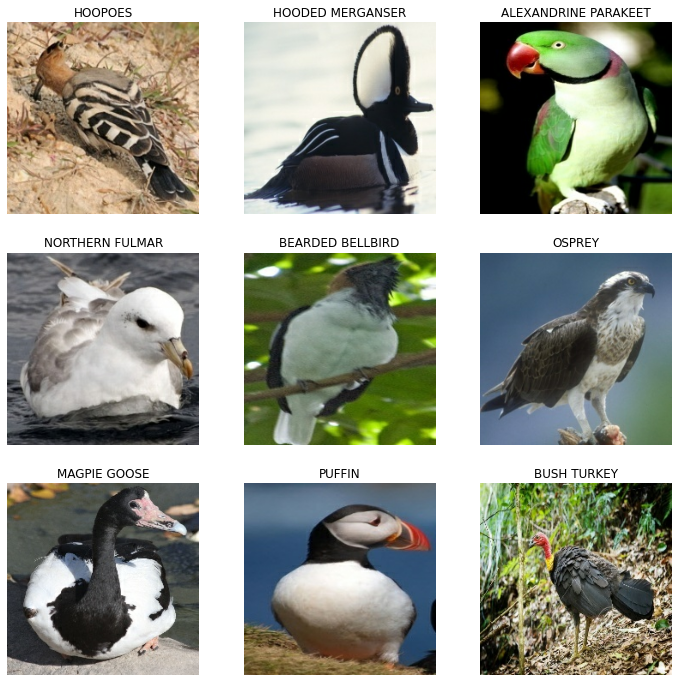

In [4]:
labels = train_data.class_names
plt.figure(figsize=(12,12))
for image, label in train_data.take(1):
  
  for i in range(9):
    
    plt.subplot(3,3, i+1)  
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(labels[tf.argmax(label[i])])
    plt.axis("off")

In [5]:
model = tf.keras.applications.EfficientNetB5(include_top= False, weights = "imagenet")

115277824/115263384 [==============================] - 1s 0us/step


In [6]:
from tensorflow.keras import layers

for layer in model.layers[:-5]:
    model.trainable = False


ip = tf.keras.Input(shape=(224,224,3))

mod = model(ip)
mod = layers.GlobalAveragePooling2D()(mod)

op = layers.Dense(400, activation="sigmoid")(mod)

model_2 = tf.keras.Model(ip,op)
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, None, None, 2048)  28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 400)               819600    
Total params: 29,333,127
Trainable params: 819,600
Non-trainable params: 28,513,527
_________________________________________________________________


In [7]:
model_2.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [8]:
model_2.fit(train_data,
              epochs = 5,
              steps_per_epoch = len(train_data),
              validation_data = val_data,
              validation_steps = len(val_data)
              )

Epoch 1/5


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'
2022-04-05 02:29:31.768275: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1825/1825 [==============================] - 283s 145ms/step - loss: 0.0160 - accuracy: 0.6866 - val_loss: 0.0035 - val_accuracy: 0.9250
Epoch 2/5
1825/1825 [==============================] - 268s 146ms/step - loss: 0.0035 - accuracy: 0.9022 - val_loss: 0.0020 - val_accuracy: 0.9490
Epoch 3/5
1825/1825 [==============================] - 262s 143ms/step - loss: 0.0023 - accuracy: 0.9332 - val_loss: 0.0015 - val_accuracy: 0.9605
Epoch 4/5
1825/1825 [==============================] - 269s 147ms/step - loss: 0.0018 - accuracy: 0.9486 - val_loss: 0.0012 - val_accuracy: 0.9645
Epoch 5/5
1825/1825 [==============================] - 272s 148ms/step - loss: 0.0014 - accuracy: 0.9611 - val_loss: 0.0011 - val_accuracy: 0.9650


In [9]:
model_2_eval = model_2.evaluate(test_data)

63/63 [==============================] - 10s 136ms/step - loss: 8.5674e-04 - accuracy: 0.9810


In [10]:
print(f"Model Accuracy: {model_2_eval[1]*100 : 0.2f}%")

Model Accuracy:  98.10%


In [11]:
from keras.models import load_model
model.save('mod.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [12]:
from keras.preprocessing import image
from keras import losses
from sklearn.metrics import log_loss
from glob import glob
import os
import csv 

In [13]:
test_labels = test_data.class_names

len(test_labels)

400

In [14]:
data_dir = '../input/csc4851-homework4/birds_400'  
train_cls = os.listdir(data_dir + "/train")

In [15]:
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/224
    return np.expand_dims(x, axis=0)
bce = losses.BinaryCrossentropy()

In [16]:
template = [0]*400
ll = {}
test_images = glob("/kaggle/input/csc4851-homework4/birds_400/test/" + "*/*.jpg")

for path in test_images:
    result = model_2.predict([prepare(path)])
    actual_cls = path.split('/')[-2]
    actual_cls = "BLACK & YELLOW  BROADBILL" if actual_cls == "BLACK & YELLOW BROADBILL" else actual_cls
    actual_index = train_cls.index(actual_cls)
    template[actual_index] = 1
    log_loss_current = bce(template, result[0]).numpy()
    if actual_index in ll:
        ll[actual_index] += (log_loss_current)/100
    else:
        ll[actual_index] = (log_loss_current)/100
    template[actual_index] = 0

ll

{0: 0.0038834184408187873,
 1: 0.003997920230031014,
 2: 0.004189658164978027,
 3: 0.004320045784115791,
 4: 0.0037896168977022172,
 5: 0.004446775987744331,
 6: 0.003529128879308701,
 7: 0.00405553825199604,
 8: 0.004623702466487885,
 9: 0.004220131635665893,
 10: 0.00331303209066391,
 11: 0.005245840921998024,
 12: 0.003859839290380478,
 13: 0.004585619047284125,
 14: 0.003476339057087899,
 15: 0.003777262344956398,
 16: 0.004496908597648144,
 17: 0.004696946367621422,
 18: 0.004314334914088249,
 19: 0.003891145586967468,
 20: 0.0034645607322454455,
 21: 0.004542980417609215,
 22: 0.004115176051855088,
 23: 0.004712464436888695,
 24: 0.004965224117040634,
 25: 0.003464912325143814,
 26: 0.0034590309113264085,
 27: 0.003813993483781814,
 28: 0.003991015329957008,
 29: 0.005523408725857735,
 30: 0.004039743319153786,
 31: 0.004199631065130233,
 32: 0.003336551450192928,
 33: 0.005070644915103912,
 34: 0.003440201058983803,
 35: 0.004359996169805527,
 36: 0.004251431971788407,
 37: 0.00

In [17]:
id_bird = list(ll.keys())
values = list(ll.values())
abc = open('submission.csv', 'w')
writer = csv.writer(abc)
writer.writerow(['id','birds'])
for index in range(len(id_bird)):
    writer.writerow([id_bird[index],values[index]])
